In [2]:
import numpy as np
import pandas as pd

from scipy.stats import mode

import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
matplotlib.rcParams.update({'font.size': 14})

In [6]:
DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './test.csv'

In [182]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [7]:
df = pd.read_csv(DATASET_PATH, sep=',')

df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


In [8]:
# Проверяем пустые значения

In [9]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [ ]:
# Восполняем значения LifeSquare

In [10]:
df['LifeSquare_nan'] = 0
df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
df['LifeSquare_nan'].value_counts()

0    7887
1    2113
Name: LifeSquare_nan, dtype: int64

In [11]:
median = df['LifeSquare'].median()
df['LifeSquare'] = df['LifeSquare'].fillna(median)

In [14]:
# Восполняем значения Healthcare_1

In [12]:
median = df['Healthcare_1'].median()
df['Healthcare_1'].fillna(median, inplace=True)

In [107]:
df.rename(columns={'Helthcare_2':'Healthcare_2'}, inplace=True)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,LifeSquare_nan,lifesq_oversq,DistrictSize,MedPriceByDistrict,ecology_cat,year_cat,MedPriceByEcologyYear
0,11809,27,3.0,115.027311,32.781260,10.0,4,4.0,2014,0.075424,...,0,1,305018.871089,1,0.284987,851,213530.788443,2,5,186877.201998
1,3013,22,1.0,39.832524,23.169223,8.0,7,7.0,1966,0.118537,...,0,1,177734.553407,0,0.581666,78,146032.829834,3,2,187475.382423
2,8215,1,3.0,78.342215,47.671972,10.0,2,2.0,1988,0.025609,...,1,1,282078.720850,0,0.608509,652,244005.272380,2,3,228274.921944
3,2352,1,1.0,40.409907,32.781260,3.0,10,10.0,1977,0.007122,...,1,1,168106.007630,1,0.811218,652,146735.671740,1,2,188867.803052
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,1,343995.102962,0,0.599867,89,201584.441255,3,2,187475.382423


In [ ]:
# Визуализируем целевую переменную

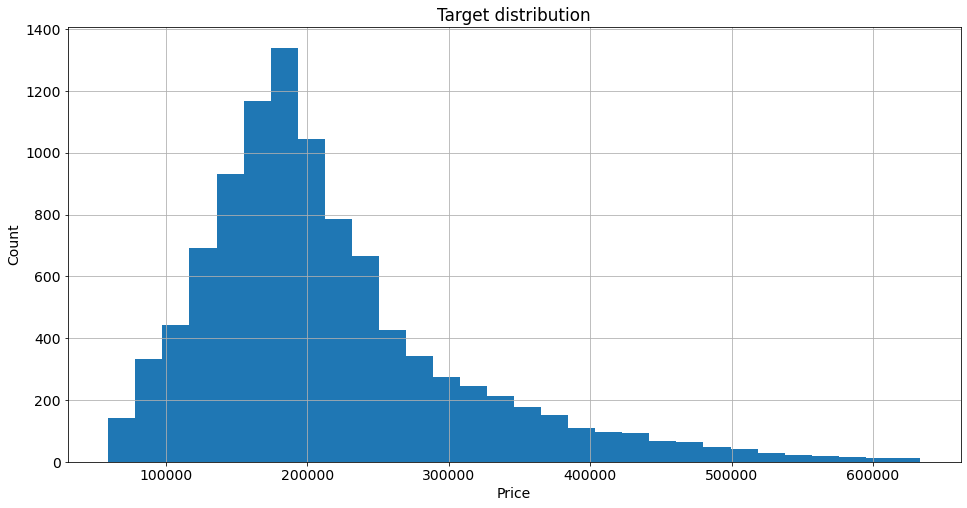

In [14]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [53]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,LifeSquare_nan,lifesq_oversq
count,10000.00000,10000.000000,10000.000000,10000.000000,9479.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.329456,34.317403,6.191300,8.526700,7.70040,1984.872400,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.211300,0.583158
std,4859.01902,43.587592,0.839512,21.028169,15.298486,2.739024,5.241148,5.30406,18.416347,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.408251,0.209236
min,0.00000,0.000000,0.000000,15.000000,10.000000,3.000000,1.000000,0.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,24.484228,3.000000,4.000000,4.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,0.000000,0.517033
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,7.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.598807
75%,12592.50000,75.000000,2.000000,65.900625,39.010546,8.000000,12.000000,11.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,0.000000,0.679600
max,16798.00000,209.000000,19.000000,641.065193,638.163193,12.000000,42.000000,42.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,0.999949


In [ ]:
# Наблюдения за результатом функции описания данных
1. Максимальное значение жилой площади больше, чем максимальное значение площади. Что невозможно.
    Нужно ограничить жилую площадь на основе данных общей площади.
2. Максимальное значение площади кухни 2014, что вряд ли корректно. Значение 2014 вероятнее всего год.
3. Минимальные значения общей площади, жилой и кухни слишком маленькие - значения должны быть больше.
3. Максимальный этаж квартиры выше, чем этажность дома.
4. Неадекватное значение года постройки - больше чем текущий год.

In [20]:
# Обработка неподходящих данных

In [41]:
# Для данных, у которых значение жилой площади меньше, чем общей - вычислить соотношение жилой и общей.
# Для тех значений, где соотношение меньше 1 определяем среднее.
# Далее для некорректных значений жилой площади определяем её как произведение общей на вычисленное значение среднего соотношения.


In [38]:
df['lifesq_oversq'] = 0
df.loc[df['Square'] > df['LifeSquare'], 'lifesq_oversq'] = (df['LifeSquare'] / df['Square'])
mean_lfsq_ovrsq = df.loc[df['lifesq_oversq'] > 0, ['lifesq_oversq']].mean()
df.loc[df['Square'] < df['LifeSquare'], 'LifeSquare'] = (df['Square'] * mean_lfsq_ovrsq)

In [45]:
# Корректируем минимальные значения площадей
df.loc[df['Square'] < 15, 'Square'] = 15
df.loc[df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [43]:
# Корректируем значения площади кухни
condition = (df['KitchenSquare'].isna()) \
             | (df['KitchenSquare'] > df['KitchenSquare'].quantile(.975))
        
df.loc[condition, 'KitchenSquare'] = df['KitchenSquare'].median()

df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [47]:
# Корректируем этажность дома. Если этаж больше этажности - указываем последний этаж дома.
df.loc[df['Floor'] < df['HouseFloor'], 'HouseFloor'] = df['Floor']

In [52]:
# Если год постройки позже текущего - заменяем на текущий.
current_year = (datetime.now().year - 1)
df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year

In [ ]:
# Построение новых признаков

In [57]:
binary_to_numbers = {'A': 0, 'B': 1}

df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)

In [56]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [58]:
district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [59]:
df = df.merge(district_size, on='DistrictId', how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,lifesq_oversq,DistrictSize
0,11809,27,3.0,115.027311,32.781260,10.0,4,4.0,2014,0.075424,...,3097,0,900.0,0,0,1,305018.871089,1,0.284987,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,7.0,1966,0.118537,...,6207,1,1183.0,1,0,1,177734.553407,0,0.581666,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,2.0,1988,0.025609,...,5261,0,240.0,3,1,1,282078.720850,0,0.608509,652
3,2352,1,1.0,40.409907,32.781260,3.0,10,10.0,1977,0.007122,...,264,0,900.0,0,1,1,168106.007630,1,0.811218,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,900.0,0,6,1,343995.102962,0,0.599867,89


In [67]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202706.090239


In [69]:
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,lifesq_oversq,DistrictSize,MedPriceByDistrict
0,11809,27,3.0,115.027311,32.781260,10.0,4,4.0,2014,0.075424,...,0,900.0,0,0,1,305018.871089,1,0.284987,851,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,7.0,1966,0.118537,...,1,1183.0,1,0,1,177734.553407,0,0.581666,78,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,2.0,1988,0.025609,...,0,240.0,3,1,1,282078.720850,0,0.608509,652,244005.272380
3,2352,1,1.0,40.409907,32.781260,3.0,10,10.0,1977,0.007122,...,0,900.0,0,1,1,168106.007630,1,0.811218,652,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,900.0,0,6,1,343995.102962,0,0.599867,89,201584.441255


In [96]:
# Преобразовываем показатель экологии в категориальный.

def ecology_to_cat(X):

    X['ecology_cat'] = 0

    X.loc[X['Ecology_1'] <= 0.02, 'ecology_cat'] = 1  
    X.loc[(X['Ecology_1'] > 0.02) & (X['Ecology_1'] <= 0.1), 'ecology_cat'] = 2
    X.loc[(X['Ecology_1'] > 0.1) & (X['Ecology_1'] <= 0.3), 'ecology_cat'] = 3
    X.loc[X['Ecology_1'] > 0.3, 'ecology_cat'] = 4

    return X

# Преобразовываем показатель года в категориальный с помощью функции cat.

def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [97]:
df = ecology_to_cat(df)
df = year_to_cat_pandas(df)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,lifesq_oversq,DistrictSize,MedPriceByDistrict,ecology_cat,year_cat
0,11809,27,3.0,115.027311,32.781260,10.0,4,4.0,2014,0.075424,...,0,0,1,305018.871089,1,0.284987,851,213530.788443,2,5
1,3013,22,1.0,39.832524,23.169223,8.0,7,7.0,1966,0.118537,...,1,0,1,177734.553407,0,0.581666,78,146032.829834,3,2
2,8215,1,3.0,78.342215,47.671972,10.0,2,2.0,1988,0.025609,...,3,1,1,282078.720850,0,0.608509,652,244005.272380,2,3
3,2352,1,1.0,40.409907,32.781260,3.0,10,10.0,1977,0.007122,...,0,1,1,168106.007630,1,0.811218,652,146735.671740,1,2
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0.599867,89,201584.441255,3,2


In [98]:
med_price_by_ecology_year = df.groupby(['year_cat', 'ecology_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcologyYear'})
med_price_by_ecology_year.head()

,year_cat,ecology_cat,MedPriceByEcologyYear
0,0,1,421851.953639
1,0,2,343367.352875
2,0,3,321506.277104
3,0,4,309988.239477
4,1,1,566669.480448
5,1,3,310305.074733
6,2,1,188867.803052
7,2,2,181627.054202
8,2,3,187475.382423
9,2,4,177570.386095


In [99]:
df = df.merge(med_price_by_ecology_year, on=['year_cat', 'ecology_cat'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,LifeSquare_nan,lifesq_oversq,DistrictSize,MedPriceByDistrict,ecology_cat,year_cat,MedPriceByEcologyYear
0,11809,27,3.0,115.027311,32.781260,10.0,4,4.0,2014,0.075424,...,0,1,305018.871089,1,0.284987,851,213530.788443,2,5,186877.201998
1,3013,22,1.0,39.832524,23.169223,8.0,7,7.0,1966,0.118537,...,0,1,177734.553407,0,0.581666,78,146032.829834,3,2,187475.382423
2,8215,1,3.0,78.342215,47.671972,10.0,2,2.0,1988,0.025609,...,1,1,282078.720850,0,0.608509,652,244005.272380,2,3,228274.921944
3,2352,1,1.0,40.409907,32.781260,3.0,10,10.0,1977,0.007122,...,1,1,168106.007630,1,0.811218,652,146735.671740,1,2,188867.803052
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,1,343995.102962,0,0.599867,89,201584.441255,3,2,187475.382423


In [163]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.mean_lfsq_ovrsq = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
      
    
    def transform(self, X):
        """Трансформация данных"""

        # LifeSquare
        X['lifesq_oversq'] = 0
        X.loc[X['Square'] > X['LifeSquare'], 'lifesq_oversq'] = (X['LifeSquare'] / X['Square'])
        mean_lfsq_ovrsq = X.loc[X['lifesq_oversq'] > 0, ['lifesq_oversq']].mean()
        X.loc[X['Square'] < X['LifeSquare'], 'LifeSquare'] = (X['Square'] * mean_lfsq_ovrsq)
        
        # Корректируем минимальные значения площадей
        X.loc[X['Square'] < 15, 'Square'] = 15
        X.loc[X['LifeSquare'] < 10, 'LifeSquare'] = 10
    
    
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        
        # Корректируем этажность дома. Если этаж больше этажности - указываем последний этаж дома.
        X.loc[X['Floor'] < X['HouseFloor'], 'HouseFloor'] = X['Floor']
        
        # HouseYear
        current_year = (datetime.now().year - 1)
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
              
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        X.fillna(self.medians, inplace=True)
        
        return X

In [173]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_eclolgy_year = None
        self.house_year_max = None
        self.ecology_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## ecology, year
        if y is not None:
            self.ecology_max = df['Ecology_1'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.ecology_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_ecology_year = df.groupby(['year_cat', 'ecology_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByEcologyYear'})
            self.med_price_by_ecology_year_median = self.med_price_by_ecology_year['MedPriceByEcologyYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.ecology_to_cat(X)  # + столбец ecology_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_ecology_year is not None:
            X = X.merge(self.med_price_by_ecology_year, on=['year_cat', 'ecology_cat'], how='left')
            X.fillna(self.med_price_by_ecology_year_median, inplace=True)
        
        return X
    
    def ecology_to_cat(self, X):
        X['ecology_cat'] = 0

        X.loc[X['Ecology_1'] <= 0.02, 'ecology_cat'] = 1  
        X.loc[(X['Ecology_1'] > 0.02) & (X['Ecology_1'] <= 0.1), 'ecology_cat'] = 2
        X.loc[(X['Ecology_1'] > 0.1) & (X['Ecology_1'] <= 0.3), 'ecology_cat'] = 3
        X.loc[X['Ecology_1'] > 0.3, 'ecology_cat'] = 4

        return X

     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X


In [83]:
# Отбор признаков

In [108]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Healthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'lifesq_oversq',
 'DistrictSize',
 'MedPriceByDistrict',
 'ecology_cat',
 'year_cat',
 'MedPriceByEcologyYear']

In [177]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['DistrictSize', 'new_district',
                     'MedPriceByDistrict', 'MedPriceByEcologyYear']

target_name = 'Price'

In [ ]:
# Разбиваем данные на тестовые и тренировочные

In [164]:
train_df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(PREPARED_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [165]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [166]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 19), (3300, 19), (5000, 19))

In [174]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [178]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [179]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [ ]:
# Построение модели

In [180]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.966
Test R2:	0.7


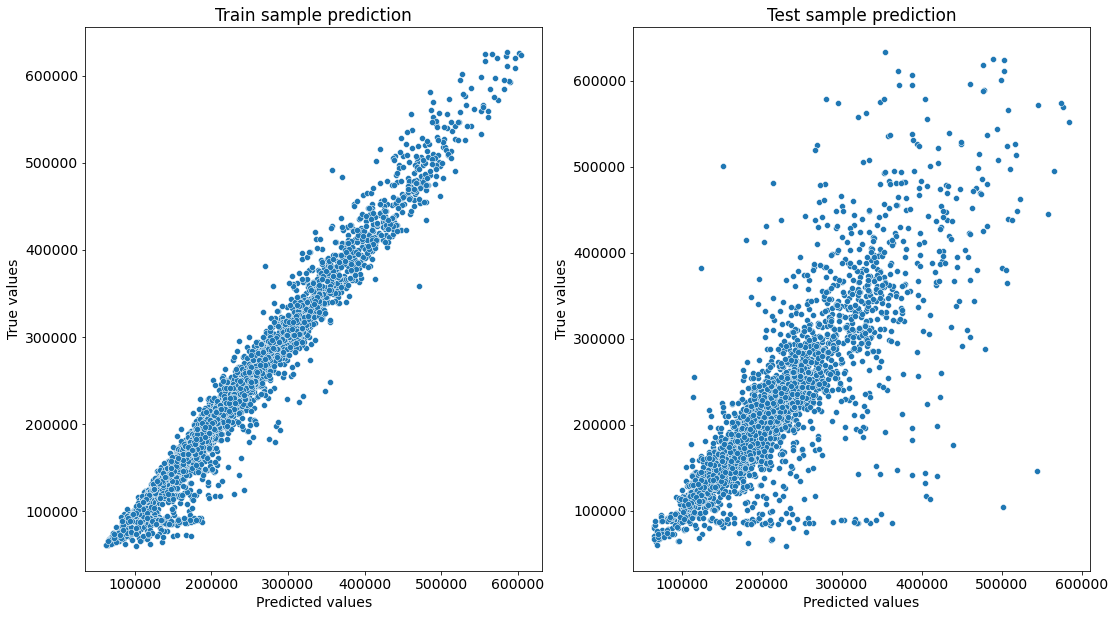

In [183]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [184]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [185]:
predictions = rf_model.predict(test_df)
predictions

array([158453.94843105, 120744.83033602, 138584.74511861, ...,
       149741.10263554, 187154.00401154, 219390.28131171])

In [186]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,158453.948431
1,5925,120744.830336
2,960,138584.745119
3,3848,166495.319489
4,746,169570.079548


In [187]:
submit.to_csv('SYA_submit.csv', index=False)